# HR Analytics - Predict Employee Attrition

#### Import all necessary libraries and modules

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import joblib
import shap

#### Set a global random seed (42) for reproducible results

In [6]:
np.random.seed(42)

#### Load the “HR_Analytics.csv” dataset into DataFrame `df`

In [8]:
df = pd.read_csv('HR_Analytics.csv')

#### Data Set Exploration

In [10]:
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Dataset Shape: (1480, 38)

First 5 rows:
   EmpID  Age AgeGroup Attrition     BusinessTravel  DailyRate  \
0  RM297   18    18-25       Yes      Travel_Rarely        230   
1  RM302   18    18-25        No      Travel_Rarely        812   
2  RM458   18    18-25       Yes  Travel_Frequently       1306   
3  RM728   18    18-25        No         Non-Travel        287   
4  RM829   18    18-25       Yes         Non-Travel        247   

               Department  DistanceFromHome  Education EducationField  ...  \
0  Research & Development                 3          3  Life Sciences  ...   
1                   Sales                10          3        Medical  ...   
2                   Sales                 5          3      Marketing  ...   
3  Research & Development                 5          2  Life Sciences  ...   
4  Research & Development                 8          1        Medical  ...   

   RelationshipSatisfaction  StandardHours  StockOptionLevel  \
0                         3  

In [11]:
print("\nData Types and Missing Values:")
print(df.info())


Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmpID                     1480 non-null   object 
 1   Age                       1480 non-null   int64  
 2   AgeGroup                  1480 non-null   object 
 3   Attrition                 1480 non-null   object 
 4   BusinessTravel            1480 non-null   object 
 5   DailyRate                 1480 non-null   int64  
 6   Department                1480 non-null   object 
 7   DistanceFromHome          1480 non-null   int64  
 8   Education                 1480 non-null   int64  
 9   EducationField            1480 non-null   object 
 10  EmployeeCount             1480 non-null   int64  
 11  EmployeeNumber            1480 non-null   int64  
 12  EnvironmentSatisfaction   1480 non-null   int64  
 13  Gender                    1480 

In [12]:
print("\nSummary Statistics:")
print(df.describe(include='all'))


Summary Statistics:
         EmpID          Age AgeGroup Attrition BusinessTravel    DailyRate  \
count     1480  1480.000000     1480      1480           1480  1480.000000   
unique    1470          NaN        5         2              4          NaN   
top     RM1467          NaN    26-35        No  Travel_Rarely          NaN   
freq         2          NaN      611      1242           1042          NaN   
mean       NaN    36.917568      NaN       NaN            NaN   801.384459   
std        NaN     9.128559      NaN       NaN            NaN   403.126988   
min        NaN    18.000000      NaN       NaN            NaN   102.000000   
25%        NaN    30.000000      NaN       NaN            NaN   465.000000   
50%        NaN    36.000000      NaN       NaN            NaN   800.000000   
75%        NaN    43.000000      NaN       NaN            NaN  1157.000000   
max        NaN    60.000000      NaN       NaN            NaN  1499.000000   

                    Department  DistanceFr

#### Check for duplicate rows

In [14]:
print("\nNumber of duplicate rows:", df.duplicated().sum())


Number of duplicate rows: 7


#### Drop duplicate rows and Verify that duplicates have been removed

In [16]:
df = df.drop_duplicates()

print("\nNumber of duplicate rows after dropping:", df.duplicated().sum())


Number of duplicate rows after dropping: 0


#### Check class distribution

In [18]:
print("\nAttrition Distribution:")
print(df['Attrition'].value_counts(normalize=True))


Attrition Distribution:
Attrition
No     0.839104
Yes    0.160896
Name: proportion, dtype: float64


## Data Cleaning and Preprocessing

#### Drop unnecessary columns

In [21]:
cols_to_drop = ['EmpID', 'EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours']
df = df.drop(cols_to_drop, axis=1)

#### Handle missing values if any

In [23]:
print("\nMissing values before handling:")
print(df.isnull().sum())


Missing values before handling:
Age                          0
AgeGroup                     0
Attrition                    0
BusinessTravel               0
DailyRate                    0
Department                   0
DistanceFromHome             0
Education                    0
EducationField               0
EnvironmentSatisfaction      0
Gender                       0
HourlyRate                   0
JobInvolvement               0
JobLevel                     0
JobRole                      0
JobSatisfaction              0
MaritalStatus                0
MonthlyIncome                0
SalarySlab                   0
MonthlyRate                  0
NumCompaniesWorked           0
OverTime                     0
PercentSalaryHike            0
PerformanceRating            0
RelationshipSatisfaction     0
StockOptionLevel             0
TotalWorkingYears            0
TrainingTimesLastYear        0
WorkLifeBalance              0
YearsAtCompany               0
YearsInCurrentRole           0
YearsS

#### For simplicity, we'll drop rows with missing values

In [25]:
df = df.dropna()

#### Identify categorical features (excluding target) for encoding

In [27]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('Attrition')  # Target variable

#### Apply LabelEncoder to all categorical columns and store encoders

In [29]:
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

#### Convert target variable to binary

In [31]:
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

## Feature Engineering

#### Create a feature for total years in company without promotion

In [34]:
df['YearsWithoutPromotion'] = df['YearsAtCompany'] - df['YearsSinceLastPromotion']

#### Visualize attrition patterns

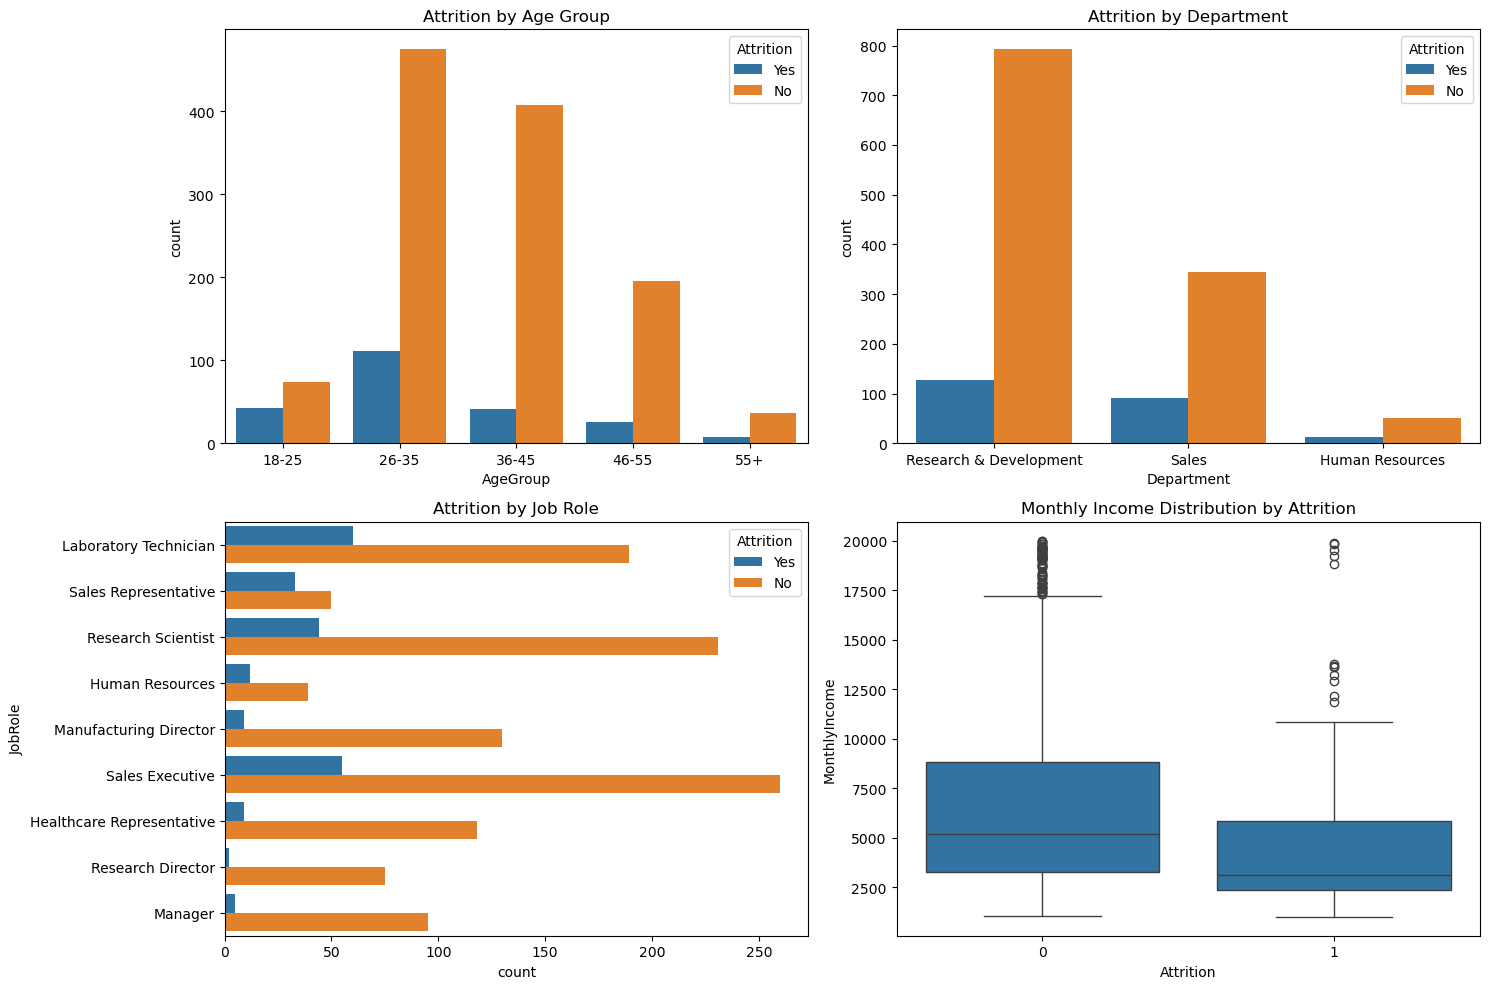

In [36]:
plt.figure(figsize=(15, 10))

# Attrition by Age Group
plt.subplot(2, 2, 1)
ax = sns.countplot(x=label_encoders['AgeGroup'].inverse_transform(df['AgeGroup']), 
                  hue=df['Attrition'].map({0: 'No', 1: 'Yes'}),
                  data=df)
plt.title('Attrition by Age Group')
plt.xlabel('AgeGroup')

# Attrition by Department
plt.subplot(2, 2, 2)
ax = sns.countplot(x=label_encoders['Department'].inverse_transform(df['Department']), 
                  hue=df['Attrition'].map({0: 'No', 1: 'Yes'}),
                  data=df)
plt.title('Attrition by Department')
plt.xlabel('Department')

# Attrition by Job Role
plt.subplot(2, 2, 3)
ax = sns.countplot(y=label_encoders['JobRole'].inverse_transform(df['JobRole']), 
                  hue=df['Attrition'].map({0: 'No', 1: 'Yes'}),
                  data=df)
plt.title('Attrition by Job Role')
plt.ylabel('JobRole')

# Attrition by Monthly Income
plt.subplot(2, 2, 4)
sns.boxplot(x='Attrition', y='MonthlyIncome', data=df)
plt.title('Monthly Income Distribution by Attrition')

plt.tight_layout()
plt.show()

#### Correlation Analysis

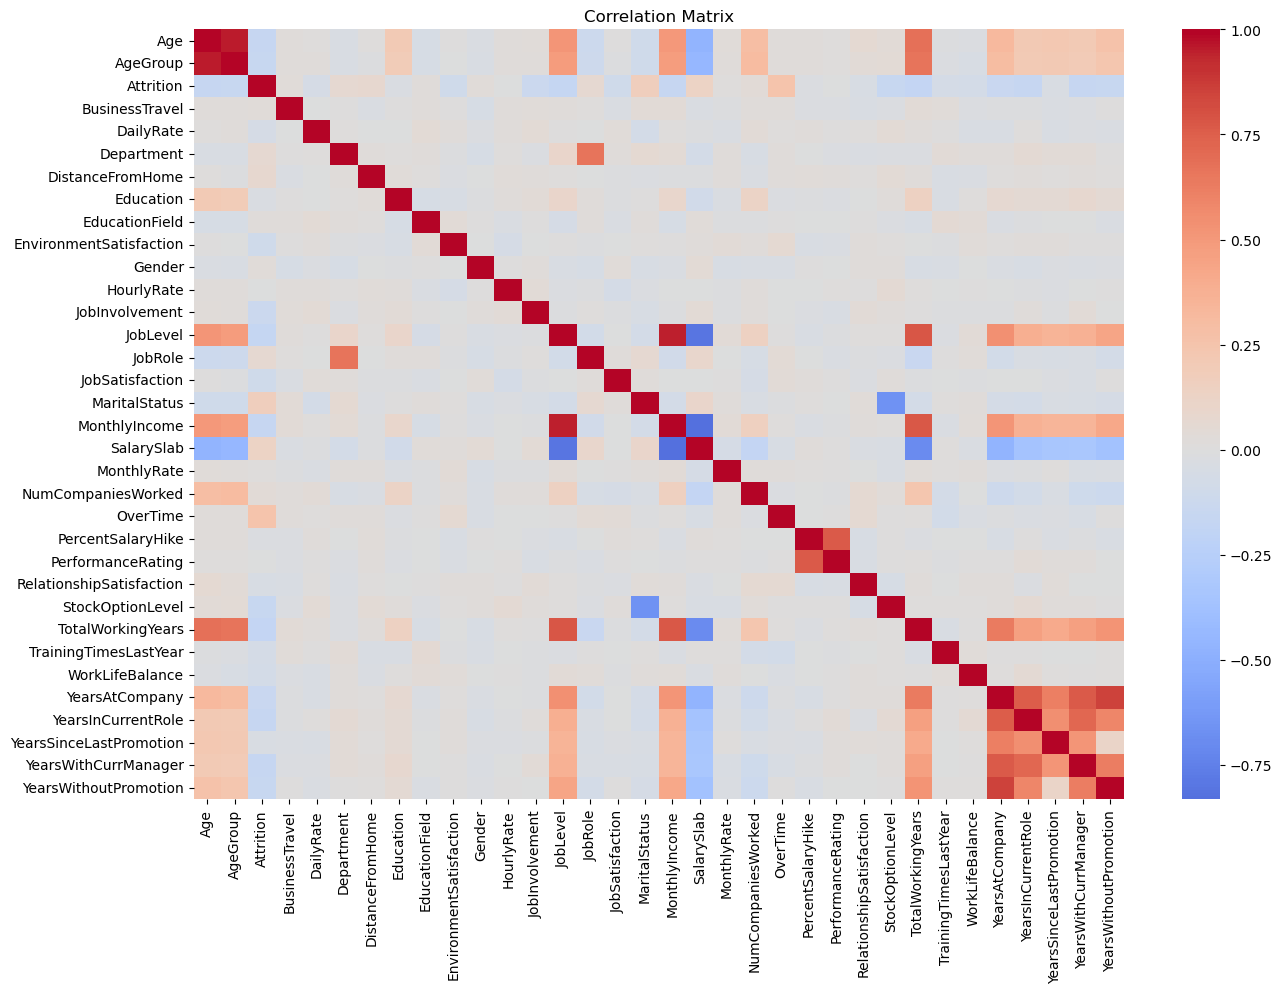

In [38]:
plt.figure(figsize=(15, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

## Feature Selection

#### Separate features and target

In [41]:
X = df.drop('Attrition', axis=1)
y = df['Attrition']

#### Feature selection using ANOVA F-value

In [43]:
selector = SelectKBest(f_classif, k=15)
X_selected = selector.fit_transform(X, y)

#### Retrieve names of the top-k selected features

In [45]:
selected_features = X.columns[selector.get_support()]
print("\nSelected Features:")
print(selected_features)


Selected Features:
Index(['Age', 'AgeGroup', 'JobInvolvement', 'JobLevel', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'SalarySlab', 'OverTime',
       'StockOptionLevel', 'TotalWorkingYears', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsWithCurrManager', 'YearsWithoutPromotion'],
      dtype='object')


#### Update feature matrix X to include only selected features

In [47]:
X = X[selected_features]

#### Split data into training and testing sets

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

#### Address class imbalance on the training set using SMOTE

In [51]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nClass distribution before SMOTE:", np.bincount(y_train))
print("Class distribution after SMOTE:", np.bincount(y_train_res))


Class distribution before SMOTE: [831 160]
Class distribution after SMOTE: [831 831]


#### Scale features with StandardScaler for normalized input to model

In [53]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

## Model Building with Random Forest

#### Initialize RandomForestClassifier, fit on training data, then make predictions on tet set


In [56]:
# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt']
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                          cv=5, n_jobs=-1, verbose=2, scoring='roc_auc')
grid_search.fit(X_train_scaled, y_train_res)

# Get best parameters
best_params = grid_search.best_params_
print("\nBest Parameters:", best_params)

# Train model with best parameters
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train_scaled, y_train_res)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


RandomForestClassifier(n_estimators=300, random_state=42)

## Model Evaluation

In [58]:
# Predictions
y_pred = best_rf.predict(X_test_scaled)
y_pred_proba = best_rf.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nAccuracy Score:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       356
           1       0.38      0.30      0.34        69

    accuracy                           0.80       425
   macro avg       0.62      0.60      0.61       425
weighted avg       0.79      0.80      0.80       425


Confusion Matrix:
[[321  35]
 [ 48  21]]

Accuracy Score: 0.8047058823529412
ROC AUC Score: 0.7125671714704445


#### Plot ROC curve and compute ROC AUC score for model evaluation

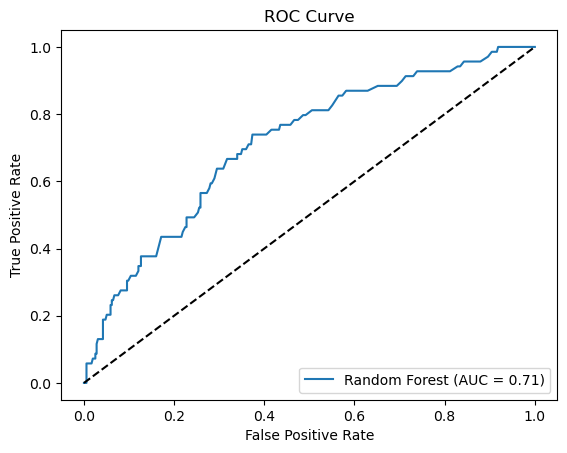

In [60]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.2f)' % roc_auc_score(y_test, y_pred_proba))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

#### Displaying the feature importance from the trained random forest

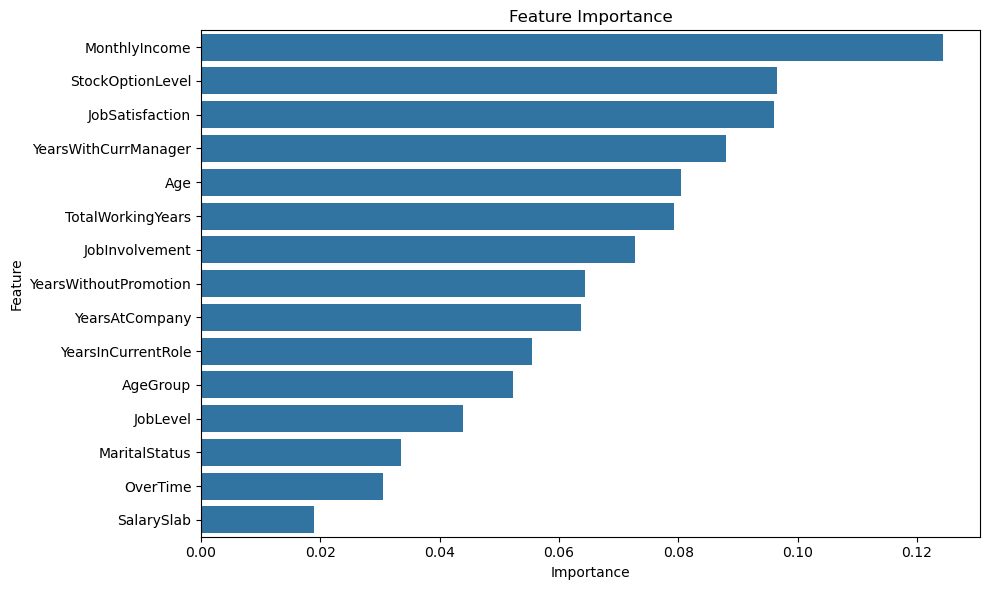

In [62]:
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

## SHAP Interpretation 

#### creating SHAP explainer  
#### computing SHAP values  
#### generating summary plot

SHAP matrix shape:    (425, 15)
Feature matrix shape: (425, 15)


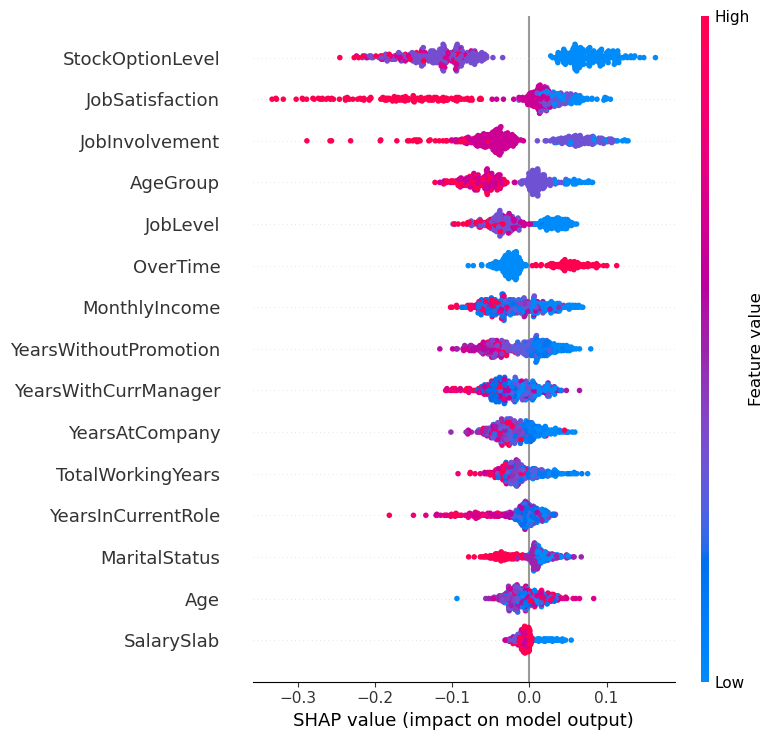

In [65]:
import numpy as np
import shap
import warnings

shap.initjs()

explainer = shap.TreeExplainer(best_rf)
raw_shap  = explainer.shap_values(X_test_scaled)

if isinstance(raw_shap, list):
    shap_arr = raw_shap[1]
elif hasattr(raw_shap, "ndim") and raw_shap.ndim == 3:
    shap_arr = raw_shap[:, :, 1]
else:
    shap_arr = raw_shap

feat_array = (
    X_test_scaled.values
    if hasattr(X_test_scaled, "values")
    else np.asarray(X_test_scaled)
)

print(f"SHAP matrix shape:    {shap_arr.shape}")
print(f"Feature matrix shape: {feat_array.shape}")
assert shap_arr.shape[1] == feat_array.shape[1], (
    f"Shape mismatch: {shap_arr.shape[1]} vs {feat_array.shape[1]}"
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    shap.summary_plot(
        shap_arr,
        feat_array,
        feature_names=selected_features,
        show=True,
        rng=np.random.default_rng(0)
    )

sample_idx = 0
fp = shap.force_plot(
    explainer.expected_value[1],
    shap_arr[sample_idx],
    feat_array[sample_idx],
    feature_names=selected_features
)

fp

#### Save the model and preprocessing objects

In [67]:
joblib.dump(best_rf, 'random_forest_attrition_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(selector, 'feature_selector.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']

#### Function to make predictions on new data

In [69]:
def predict_attrition(new_data):
    """
    Function to predict attrition for new data
    new_data: DataFrame with the same features as training data
    """
    # Load saved objects
    model = joblib.load('random_forest_attrition_model.pkl')
    scaler = joblib.load('scaler.pkl')
    selector = joblib.load('feature_selector.pkl')
    label_encoders = joblib.load('label_encoders.pkl')
    
    # Preprocess new data
    new_data = new_data.copy()
    
    # Drop unnecessary columns
    new_data = new_data.drop(['EmpID', 'EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], 
                            axis=1, errors='ignore')
    
    # Encode categorical variables
    for col, le in label_encoders.items():
        if col in new_data.columns:
            new_data[col] = le.transform(new_data[col])
    
    # Feature engineering
    if 'YearsAtCompany' in new_data.columns and 'YearsSinceLastPromotion' in new_data.columns:
        new_data['YearsWithoutPromotion'] = new_data['YearsAtCompany'] - new_data['YearsSinceLastPromotion']
    
    # Select features
    selected_features = selector.get_feature_names_out()
    new_data = new_data[selected_features]
    
    # Scale features
    new_data_scaled = scaler.transform(new_data)
     # Make predictions
    predictions = model.predict(new_data_scaled)
    prediction_probs = model.predict_proba(new_data_scaled)[:, 1]
    
    return predictions, prediction_probs

#### Example usage of `predict_attrition()` function on a sample record

In [71]:
sample_data = pd.DataFrame({
    'Age': [35],
    'AgeGroup': ['26-35'],
    'BusinessTravel': ['Travel_Rarely'],
    'DailyRate': [800],
    'Department': ['Research & Development'],
    'DistanceFromHome': [10],
    'Education': [3],
    'EducationField': ['Life Sciences'],
    'EnvironmentSatisfaction': [4],
    'Gender': ['Male'],
    'HourlyRate': [60],
    'JobInvolvement': [3],
    'JobLevel': [2],
    'JobRole': ['Research Scientist'],
    'JobSatisfaction': [4],
    'MaritalStatus': ['Married'],
     'MonthlyIncome': [5000],
    'SalarySlab': ['Upto 5k'],
    'MonthlyRate': [20000],
    'NumCompaniesWorked': [2],
    'OverTime': ['No'],
    'PercentSalaryHike': [15],
    'PerformanceRating': [3],
    'RelationshipSatisfaction': [4],
    'StockOptionLevel': [1],
    'TotalWorkingYears': [8],
    'TrainingTimesLastYear': [3],
    'WorkLifeBalance': [3],
    'YearsAtCompany': [5],
    'YearsInCurrentRole': [3],
    'YearsSinceLastPromotion': [2],
    'YearsWithCurrManager': [3]
})

prediction, probability = predict_attrition(sample_data)
print(f"\nPrediction: {'Yes' if prediction[0] == 1 else 'No'}")
print(f"Probability of Attrition: {probability[0]:.2f}")


Prediction: No
Probability of Attrition: 0.04
